In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.4f}'.format

import os
path = r'D:\REGI\0Teaching Materials\QZ Recommender System\book crossing'
os.chdir(path)

import gc
gc.collect()

# Simple Python RecommendatIon System Engine

0

In [ ]:
book = pd.read_csv('BX-Books.csv', sep=';', on_bad_lines='warn', encoding="latin-1").iloc[:,:5]
book.columns=['ISBN', 'BookTitle', 'BookAuthor', 'YearOfPublication', 'Publisher']

user = pd.read_csv('BX-Users.csv', sep=';', on_bad_lines='warn', encoding="latin-1")
user.columns = ['UserID', 'Location', 'Age']

rating = pd.read_csv('BX-Book-Ratings.csv', sep=';', on_bad_lines='warn', encoding="latin-1")
rating.columns=['UserID', 'ISBN', 'BookRating']

print('book:', book.shape, 'user:', user.shape, 'rating:',rating.shape)

Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9

Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9

Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10
Skipping line 245933: expected 8 fields, saw 9
Skipping line 251296: expected 8 fields, saw 9
Skipping line 259941: expected 8 fields, saw 9
Skipping line 261529: expected 8 fields, saw 9

C:\Users\regiv\AppData\Local\Temp\ipykernel_7368\2732590296.py:1: DtypeWarning: Columns (3) have mixed ty

book: (271360, 5) user: (278858, 3) rating: (1149780, 3)


In [ ]:
rating['ISBN'] = rating['ISBN'].str.replace(r'[^\w\d]+', '', regex=True)
book['ISBN'] = book['ISBN'].str.replace(r'[^\w\d]+', '', regex=True)

In [ ]:
book.head(2)

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada


In [ ]:
user.head(2)

,UserID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0000


In [ ]:
rating.head(2)

,UserID,ISBN,BookRating
0,276725,034545104X,0
1,276726,0155061224,5


In [ ]:
rating['BookRating'].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: BookRating, dtype: int64

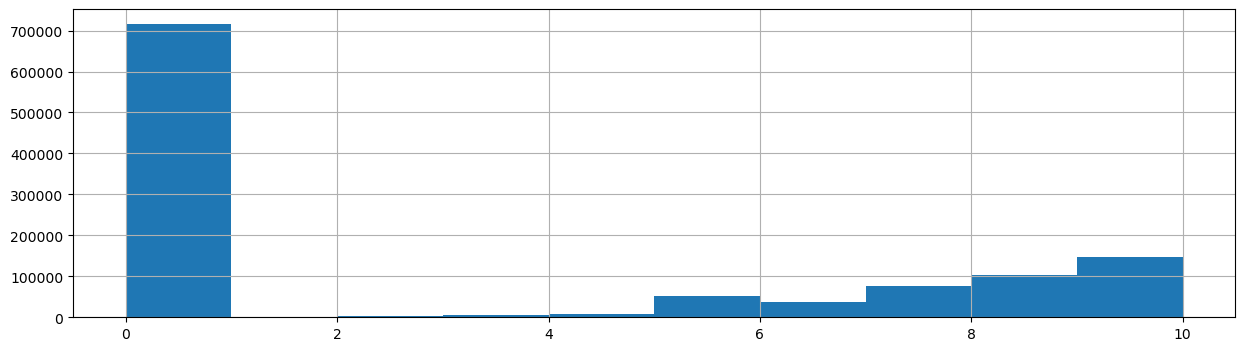

In [ ]:
# plot graph of 'ratings' column
plt.figure(figsize =(15, 4))
rating['BookRating'].hist()
plt.show()

In [ ]:
rating = pd.merge(rating, book[['ISBN', 'BookTitle']], how='left', on='ISBN')
rating['BookTitle'] = rating['BookTitle'].str.replace("'", "")
rating = rating.dropna()
rating = rating.sort_values('BookTitle')
rating.head()

,UserID,ISBN,BookRating,BookTitle
243080,55927,0590567330,0,A Light in the Storm: The Civil War Diary of ...
400876,96448,0590567330,9,A Light in the Storm: The Civil War Diary of ...
160864,35859,0590567330,0,A Light in the Storm: The Civil War Diary of ...
87471,18995,0590567330,0,A Light in the Storm: The Civil War Diary of ...
120611,27650,0563208422,5,Allo Allo: the War Diaries of Rene Artois


In [ ]:
rating.loc[rating['BookRating']==0, 'BookRating'] = np.NaN

rating['BookRating'] = rating['BookRating'].groupby(rating['BookTitle']).transform(lambda x: x.fillna(x.mean()))
rating = rating[rating['BookRating']>0]
rating['BookRating'] = rating['BookRating'].round()
rating.head()

,UserID,ISBN,BookRating,BookTitle
243080,55927,0590567330,9.0000,A Light in the Storm: The Civil War Diary of ...
400876,96448,0590567330,9.0000,A Light in the Storm: The Civil War Diary of ...
160864,35859,0590567330,9.0000,A Light in the Storm: The Civil War Diary of ...
87471,18995,0590567330,9.0000,A Light in the Storm: The Civil War Diary of ...
120611,27650,0563208422,5.0000,Allo Allo: the War Diaries of Rene Artois


In [ ]:
rating.shape

(872644, 4)

In [ ]:
rating = rating.drop_duplicates(['UserID', 'BookTitle'])
rating.shape

(867927, 4)

In [ ]:
counts1 = rating['UserID'].value_counts()
rating = rating[rating['UserID'].isin(counts1[counts1 >= 20].index)]

counts2 = rating['BookTitle'].value_counts()
rating = rating[rating['BookTitle'].isin(counts2[counts2 >= 20].index)]

rating.shape

(289271, 4)

### Rating counts

In [ ]:
book_rating_count = rating.groupby('BookTitle').agg('count').reset_index().iloc[:,:2]
book_rating_count = book_rating_count.rename(columns = {'UserID':'BookRatingCount'})
book_rating_count.head()

,BookTitle,BookRatingCount
0,10 Lb. Penalty,46
1,1001 Ways to Be Romantic,21
2,101 Dalmatians,31
3,"14,000 Things to Be Happy About",23
4,16 Lighthouse Road,52


In [ ]:
book_rating_count.describe()

,BookRatingCount
count,5665.0000
mean,51.0628
std,51.6163
min,20.0000
25%,25.0000
50%,33.0000
75%,56.0000
max,1080.0000


In [ ]:
book_rating_pivot = rating.pivot(index = 'BookTitle', columns = 'UserID', values = 'BookRating').fillna(0)
book_rating_pivot.shape

(5665, 5993)

In [ ]:
book_rating_pivot.head(2)

UserID,242,243,254,383,388,487,503,507,638,643,...,278188,278194,278202,278221,278356,278418,278535,278582,278633,278843
BookTitle,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1001 Ways to Be Romantic,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### CF - Memory Based (Item-Item)
#### kNN - Nearest books in terms of ratings

In [ ]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(book_rating_pivot)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
distances, indices = model_knn.kneighbors(book_rating_pivot, n_neighbors = 6)
print('distances: ', distances.shape, 'indices: ', indices.shape)

distances:  (5665, 6) indices:  (5665, 6)


In [ ]:
rec = pd.DataFrame(indices, columns=['book0','book1','book2','book3','book4','book5'])
rec.head()

,book0,book1,book2,book3,book4,book5
0,0,5323,5241,1020,2379,696
1,1,3220,339,3822,1445,1297
2,2,3165,3631,1183,2158,480
3,3,3095,5481,1778,5146,846
4,4,9,16,4552,1675,3462


In [ ]:
books = pd.DataFrame(book_rating_pivot.index).reset_index()
books = books.rename(columns={'index':'book0'})
books.head()

,book0,BookTitle
0,0,10 Lb. Penalty
1,1,1001 Ways to Be Romantic
2,2,101 Dalmatians
3,3,"14,000 Things to Be Happy About"
4,4,16 Lighthouse Road


In [ ]:
rec2 = rec.copy()

for i in range(0, 6):
    books = pd.DataFrame(book_rating_pivot.index).reset_index()
    books = books.rename(columns={'index':f'book{i}'})

    rec2 = pd.merge(rec2, books, on=[f'book{i}'], how='left')
    rec2 = rec2.drop(f'book{i}', axis=1)
    rec2 = rec2.rename(columns={'BookTitle':f'book{i}'})
#print(rec2.head())

In [ ]:
rec2[rec2['book0']=="1984"]

,book0,book1,book2,book3,book4,book5
5,1984,Brave New World,Animal Farm,Lord of the Flies,The Catcher in the Rye,Fahrenheit 451


In [ ]:
rec2[rec2['book0']=="101 Dalmatians"]

,book0,book1,book2,book3,book4,book5
2,101 Dalmatians,Prince and the Pauper Walt Disney,Snow White and the Seven Dwarfs,Disneys the Lion King (Little Golden Book),Jungle Book,Bears on Wheels (Bright &amp; Early Books)


In [ ]:
rec2[rec2['book0']=="Lord of the Flies"]

,book0,book1,book2,book3,book4,book5
2392,Lord of the Flies,1984,To Kill a Mockingbird,Fahrenheit 451,The Catcher in the Rye,Number the Stars (Yearling Newbery)


## CF - Model Based (Item-Item)
### SVD - similarity of books via users

In [ ]:
book_rating_pivot.shape

(5665, 5993)

In [ ]:
X = book_rating_pivot.values

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=5992, random_state=42)
svd.fit(X)

count=0
for index, cumsum in enumerate(np.cumsum(svd.explained_variance_ratio_)):
    if cumsum<=0.95:
        count+=1
    else:
        break

print(count)

2305


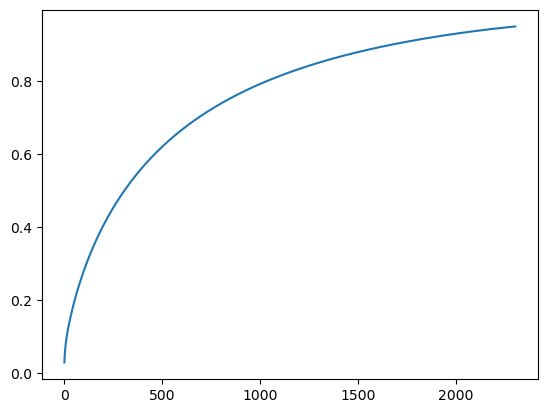

In [ ]:
SVD = TruncatedSVD(n_components=count, random_state=17)
SVD.fit(X)

plt.plot(np.cumsum(SVD.explained_variance_ratio_))
plt.show()

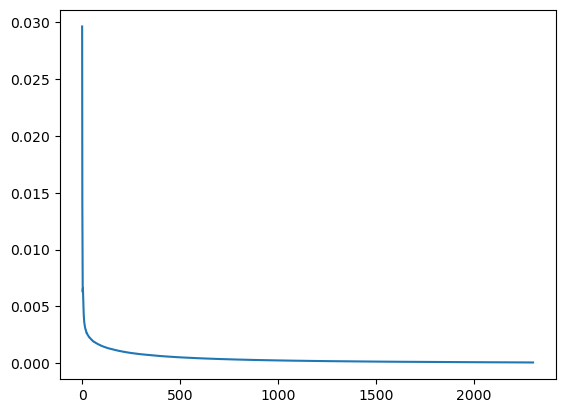

In [ ]:
plt.plot(SVD.explained_variance_ratio_)
plt.show()

In [ ]:
SVD.explained_variance_ratio_

array([2.96464970e-02, 1.39845438e-02, 1.00531090e-02, ...,
       5.19937536e-05, 5.17974995e-05, 5.15776322e-05])

In [ ]:
import sklearn
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=count, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(5665, 2305)

In [ ]:
corr = np.corrcoef(matrix)
corr.shape

(5665, 5665)

In [ ]:
book_title = book_rating_pivot.index
book_list = list(book_title)
book_1984 = book_list.index("1984")
print(book_1984)

5


In [ ]:
corr_book_1984  = corr[book_1984]

In [ ]:
corr_book_1984

array([-0.00081655,  0.01810292,  0.02679466, ...,  0.05295258,
        0.07218828,  0.07465153])

In [ ]:
list(book_title[(corr_book_1984>0.15)])

['1984',
 'Animal Farm',
 'Biblioholism: The Literary Addiction',
 'Brave New World',
 'Fahrenheit 451',
 'Fast Food Nation: The Dark Side of the All-American Meal',
 'Lord of the Flies',
 'Me Talk Pretty One Day',
 'Silence of the Lambs',
 'The Catcher in the Rye',
 'The Glass Menagerie',
 'The Hitchhikers Guide to the Galaxy',
 'To Kill a Mockingbird',
 'Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players']

In [ ]:
bklist = pd.DataFrame(corr_book_1984, columns=['corr'], index=book_title)
bklist = bklist.sort_values('corr', ascending=False)
bklist.head(10)

,corr
BookTitle,
1984,1.0000
Brave New World,0.2735
Animal Farm,0.2380
Lord of the Flies,0.2321
The Catcher in the Rye,0.1982
Fahrenheit 451,0.1831
Biblioholism: The Literary Addiction,0.1774
"Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players",0.1708
The Hitchhikers Guide to the Galaxy,0.1674


### CF - Model Based (User-Item)
#### Collaborative Filtering - Surprise

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from surprise import Reader, SVD, Dataset
from surprise.model_selection import cross_validate

In [ ]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating[['UserID', 'BookTitle', 'BookRating']], reader)

In [ ]:
svd = SVD()
cross_validate(svd, data, measures=['rmse'], cv=3, return_train_measures=True)

{'test_rmse': array([0.93076131, 0.93307215, 0.9292337 ]),
 'train_rmse': array([0.66328636, 0.66399635, 0.66568352]),
 'fit_time': (2.141247034072876, 2.219325065612793, 2.281632900238037),
 'test_time': (0.4998779296875, 0.7798244953155518, 0.6866743564605713)}

In [ ]:
svd = SVD(n_factors=5, reg_all=0.05)
cross_validate(svd, data, measures=['rmse'], cv=3, return_train_measures=True)

{'test_rmse': array([0.91616142, 0.91203093, 0.92736123]),
 'train_rmse': array([0.86033968, 0.86341493, 0.85584987]),
 'fit_time': (1.1770658493041992, 1.2658305168151855, 1.266063928604126),
 'test_time': (0.5785596370697021, 0.7181158065795898, 0.6404709815979004)}

In [ ]:
## Tuning Surprise

from surprise.model_selection import GridSearchCV
param_grid = {'n_factors': [5, 10, 25, 50], 'reg_all': [0.01, 0.05, 0.1, 0.2]}

gs = GridSearchCV(SVD, param_grid,  measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print(gs.best_params['rmse'])

{'n_factors': 5, 'reg_all': 0.05}


In [ ]:
## Train the model on the entire dataset using the fit method after converting the dataset for
## into a Surprise Trainset object using the build_full_trainset method.

trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
rr = rating[rating['UserID']==276964].sort_values(by='BookRating', ascending=False)
rr

,UserID,ISBN,BookRating,BookTitle
701,276964,0812550307,10.0000,"The Fires of Heaven (The Wheel of Time, Book 5)"
684,276964,0345354621,10.0000,The Terminal Man
691,276964,0440220602,9.0000,The Chamber
688,276964,0425104273,9.0000,The First Deadly Sin
692,276964,0446522856,9.0000,The Last Day
702,276964,0843949163,8.0000,In the Dark
699,276964,0765342987,8.0000,Kushiels Dart
704,276964,0886774802,8.0000,"Stone of Farewell (Memory, Sorrow, and Thorn, ..."
698,276964,0684867621,8.0000,The Girl Who Loved Tom Gordon : A Novel
689,276964,0425172546,7.0000,Southern Cross


In [ ]:
items = book_rating_count['BookTitle'].unique()
test = [[276964, iid, 4] for iid in items]
predictions = svd.test(test)
pred = pd.DataFrame(predictions)

In [ ]:
pred = pred.sort_values(by='est', ascending=False)
pred.head(10)

,uid,iid,r_ui,est,details
2755,276964,Natural California: A Postcard Book,4,9.9676,{'was_impossible': False}
2544,276964,Mere Christianity: A revised and enlarged edit...,4,9.9380,{'was_impossible': False}
3334,276964,Roseanne: My Life As a Woman,4,9.8927,{'was_impossible': False}
1171,276964,Dilbert: A Book of Postcards,4,9.8870,{'was_impossible': False}
1772,276964,Harry Potter and the Chamber of Secrets Postca...,4,9.8841,{'was_impossible': False}
2843,276964,"North and South (North and South Trilogy, Book 1)",4,9.8741,{'was_impossible': False}
1890,276964,Honor Bound (Honor Bound (Paperback)),4,9.8236,{'was_impossible': False}
740,276964,Calvin and Hobbes,4,9.8109,{'was_impossible': False}
3125,276964,Postmarked Yesteryear: 30 Rare Holiday Postcards,4,9.8081,{'was_impossible': False}
2723,276964,"My Sisters Keeper : A Novel (Picoult, Jodi)",4,9.8073,{'was_impossible': False}


### CF - Memory Based (Item-Item)
#### Collaborative Filtering - Surprise

In [ ]:
from surprise import KNNWithZScore, KNNWithMeans

# To use item-based cosine similarity
sim_options = {"name": "cosine"}

# Compute  similarities between items
algo = KNNWithMeans(sim_options=sim_options)

In [ ]:
trainingSet = data.build_full_trainset()
algo.fit(trainingSet)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
items = book_rating_count['BookTitle'].unique()
test = [[276964, iid, 4] for iid in items]
predictions = algo.test(test)
pred = pd.DataFrame(predictions)

In [ ]:
pred = pred.sort_values(by='est', ascending=False)
pred.head(10)

,uid,iid,r_ui,est,details
1581,276964,Fox in Socks (I Can Read It All by Myself Begi...,4,10.0000,"{'actual_k': 6, 'was_impossible': False}"
2843,276964,"North and South (North and South Trilogy, Book 1)",4,10.0000,"{'actual_k': 13, 'was_impossible': False}"
3334,276964,Roseanne: My Life As a Woman,4,10.0000,"{'actual_k': 8, 'was_impossible': False}"
2287,276964,Le Parfum : Histoire dun meurtrier,4,10.0000,"{'actual_k': 1, 'was_impossible': False}"
20,276964,52 Deck Series: 52 Ways to Celebrate Friendship,4,10.0000,"{'actual_k': 9, 'was_impossible': False}"
5315,276964,Tully,4,10.0000,"{'actual_k': 9, 'was_impossible': False}"
1890,276964,Honor Bound (Honor Bound (Paperback)),4,10.0000,"{'actual_k': 10, 'was_impossible': False}"
3435,276964,Seasons of Her Life,4,10.0000,"{'actual_k': 12, 'was_impossible': False}"
3125,276964,Postmarked Yesteryear: 30 Rare Holiday Postcards,4,10.0000,"{'actual_k': 10, 'was_impossible': False}"
2780,276964,New Vegetarian: Bold and Beautiful Recipes for...,4,10.0000,"{'actual_k': 1, 'was_impossible': False}"
